In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import os
import tarfile
import scipy.io as sio
import numpy as np
import random
import cv2
import keras

import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='/tmp/car_ims'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i][8:]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)

        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]

        # margins of 16 pixels (Crop image according to a given bounding box)
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/tmp/car_ims/train/'
        else:
            dst_folder = '/tmp/car_ims/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        dst_image = src_image[y1:y2, x1:x2]
        cv2.imwrite(dst_path, dst_image)

### Download and Separate Data

We first need to download the data from a remote server and seperate the data into training and testing sets. Note that you only need to download the data once, if you have downloaded the data before do not run the code in this section.

In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/car_ims.tgz \
  -O /tmp/car_ims.tgz

--2020-08-14 14:40:11--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘/tmp/car_ims.tgz’

/tmp/car_ims.tgz    100%[===================>]   1.82G  43.7MB/s    in 48s     

2020-08-14 14:40:59 (39.1 MB/s) - ‘/tmp/car_ims.tgz’ saved [1956628579/1956628579]



In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_annos.mat \
  -O /tmp/cars_annos.mat

--2020-08-14 14:40:59--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘/tmp/cars_annos.mat’

/tmp/cars_annos.mat 100%[===================>] 385.23K   653KB/s    in 0.6s    

2020-08-14 14:41:00 (653 KB/s) - ‘/tmp/cars_annos.mat’ saved [394471/394471]



In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat \
  -O /tmp/cars_test_annos.mat

--2020-08-14 14:41:00--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘/tmp/cars_test_annos.mat’

/tmp/cars_test_anno 100%[===================>] 181.40K   569KB/s    in 0.3s    

2020-08-14 14:41:01 (569 KB/s) - ‘/tmp/cars_test_annos.mat’ saved [185758/185758]



In [ ]:
!rm -rf /tmp/car_ims/train/
!rm -rf /tmp/car_ims/test/
!rm -rf /tmp/car_ims/valid/

Unzip the compressed data. (You do not need to understand how this works)

In [ ]:
local_tar = '/tmp/car_ims.tgz'
my_tar = tarfile.open(local_tar)
my_tar.extractall('/tmp')
my_tar.close()

In [ ]:
car_annotation= sio.loadmat('/tmp/cars_annos.mat')

annotations = car_annotation['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
labels = []
bboxes  = []
for annotation in annotations:
  bbox_x1 = annotation[0][1][0][0]
  bbox_y1 = annotation[0][2][0][0]
  bbox_x2 = annotation[0][3][0][0]
  bbox_y2 = annotation[0][4][0][0]

  class_id = annotation[0][5][0][0]
  bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
  labels.append(f'{class_id:06}')

  file_name = annotation[0][0][0]
  class_ids.append(class_id)
  fnames.append(file_name)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

save_train_data(fnames, labels, bboxes)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


### Create a data generator

In [ ]:
datagen = ImageDataGenerator()
train_iter = datagen.flow_from_directory('/tmp/car_ims/train/', target_size = (160, 160), class_mode='categorical', batch_size=64)
datagen2 = ImageDataGenerator(horizontal_flip = True)
train_iter2 = datagen2.flow_from_directory('/tmp/car_ims/train/', target_size = (160, 160), class_mode='categorical', batch_size=64)
datagen3 = ImageDataGenerator(rotation_range = 90)
train_iter3 = datagen3.flow_from_directory('/tmp/car_ims/train/', target_size = (160, 160), class_mode='categorical', batch_size=64)
test_iter = datagen.flow_from_directory('/tmp/car_ims/valid/', target_size = (160, 160), class_mode='categorical', batch_size=64)

Found 12948 images belonging to 196 classes.
Found 12948 images belonging to 196 classes.
Found 12948 images belonging to 196 classes.
Found 3237 images belonging to 196 classes.


### Build Model

In [ ]:
model = Sequential([
    Conv2D(32, (10, 10), input_shape = (160, 160, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3, 3)),
    Dropout(0.5),
    Conv2D(64, (5, 5)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3, 3)),
    Dropout(0.5),
    # Conv2D(128, (5, 5)),
    # BatchNormalization(),
    # Activation('relu'),
    # MaxPooling2D((2, 2)),
    # Dropout(0.5),
    # Conv2D(64, (5, 5)),
    # BatchNormalization(),
    # Activation('relu'),
    # MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(196, activation = 'softmax')

])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 151, 151, 32)      9632      
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 151, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 151, 151, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        2

In [ ]:
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


In [ ]:

# history = model.fit(train_iter, epochs = 100, validation_data = test_iter)

In [ ]:
import tensorflow as tf
import keras

base_model = tf.keras.applications.ResNet50(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

inputs = keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(196, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
print(model.summary())
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1179712   
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
activation_2 (Activation)    (None, 3, 3, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_______________________________________________________

In [ ]:
with tf.device("GPU:0"):
  history = model.fit(train_iter, epochs = 25, validation_data=test_iter)
  history = model.fit(train_iter2, epochs = 25, validation_data=test_iter)
  #history = model.fit(train_iter3, epochs = 25, validation_data=test_iter)


Epoch 1/25
203/203 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9670

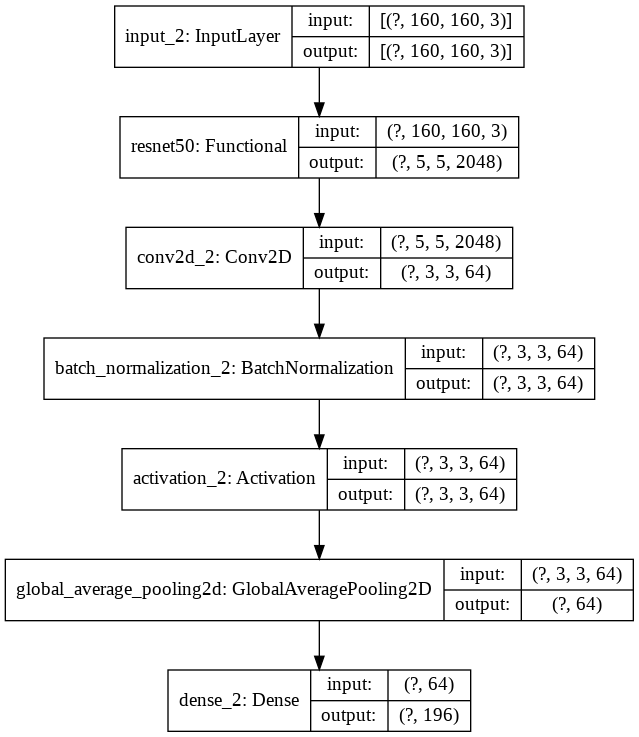

In [ ]:
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file = dot_img_file, show_shapes = True)